In [123]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix

### Read the csv file

In [69]:
df_train = pd.read_csv('../input/sadfghj/train_ekmann.csv')
df_val = pd.read_csv('../input/sadfghj/test_ekmann.csv')
df_test = pd.read_csv('../input/sadfghj/test_ekmann.csv')

### drop the column Id as it is irrelevant

In [70]:
df_train.drop('Id', inplace=True, axis=1)
df_val.drop('Id', inplace=True, axis=1)
df_test.drop('Id', inplace=True, axis=1)

since the dataset is huge for the training purpose use only 3000 rows. Please use the complete dataset.

replace - df_train=df_train[:3000]

with 
df_train

similarly with df_val,df_test


In [71]:
df_train=df_train[:3000]

In [72]:
df_train

,Text,Emotion
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,anger
...,...,...
2995,"Haha, small world, I live/work in the Twin Cit...",joy
2996,>I hope that really incredible sex is in your ...,joy
2997,oh my [NAME],surprise
2998,At 45 I'm the youngest in my run of terraces b...,surprise


In [73]:
df_val

,Text,Emotion
0,I’m really sorry about your situation :( Altho...,sadness
1,It's wonderful because it's awful. At not with.,joy
2,"Kings fan here, good luck to you guys! Will be...",joy
3,"I didn't know that, thank you for teaching me ...",joy
4,They got bored from haunting earth for thousan...,neutral
...,...,...
5422,Thanks. I was diagnosed with BP 1 after the ho...,joy
5423,Well that makes sense.,joy
5424,Daddy issues [NAME],neutral
5425,So glad I discovered that subreddit a couple m...,joy


In [74]:
df_val=df_val[:1000]

In [75]:
df_test

,Text,Emotion
0,I’m really sorry about your situation :( Altho...,sadness
1,It's wonderful because it's awful. At not with.,joy
2,"Kings fan here, good luck to you guys! Will be...",joy
3,"I didn't know that, thank you for teaching me ...",joy
4,They got bored from haunting earth for thousan...,neutral
...,...,...
5422,Thanks. I was diagnosed with BP 1 after the ho...,joy
5423,Well that makes sense.,joy
5424,Daddy issues [NAME],neutral
5425,So glad I discovered that subreddit a couple m...,joy


In [94]:
df_test=df_test[:100]

### EDA

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'testing data'}, xlabel='Emotion', ylabel='count'>

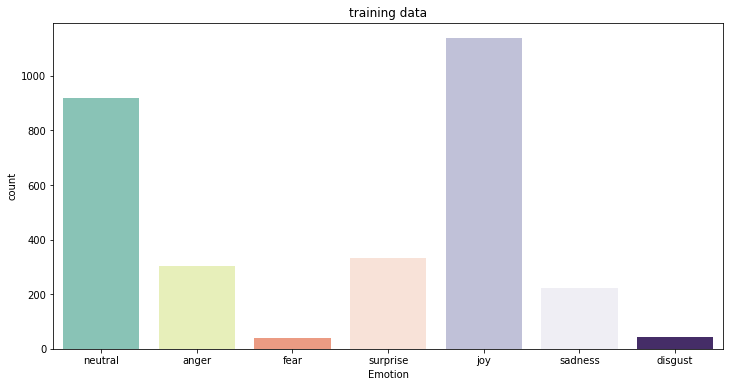

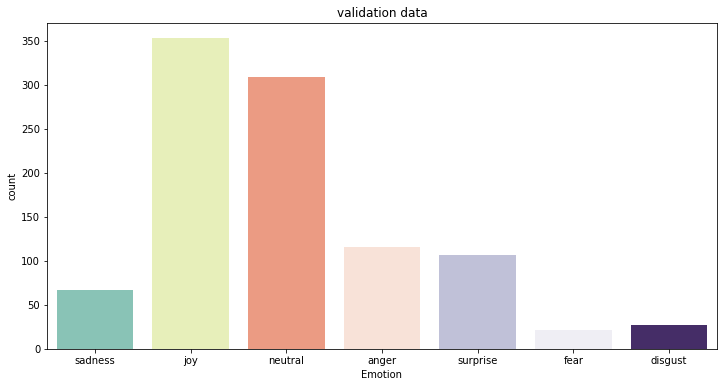

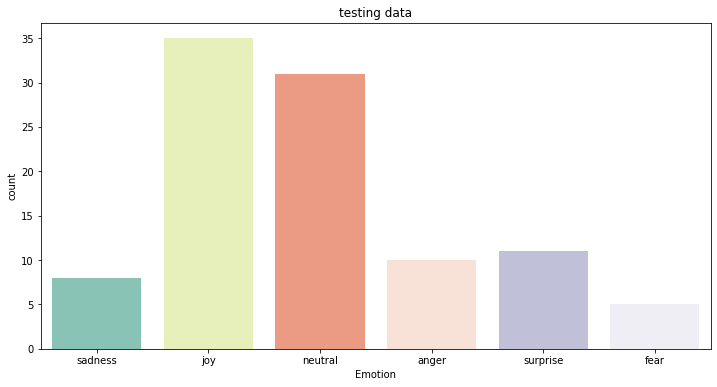

In [77]:
plt.figure(figsize = (12,6))
plt.title('training data')
sns.countplot(df_train['Emotion'], palette=['#7fcdbb','#edf8b1','#fc9272','#fee0d2','#bcbddc','#efedf5','#432371'])

plt.figure(figsize = (12,6))
plt.title('validation data')
sns.countplot(df_val["Emotion"], palette=['#7fcdbb','#edf8b1','#fc9272','#fee0d2','#bcbddc','#efedf5','#432371'])

plt.figure(figsize = (12,6))
plt.title('testing data')
sns.countplot(df_test["Emotion"], palette=['#7fcdbb','#edf8b1','#fc9272','#fee0d2','#bcbddc','#efedf5','#432371'])

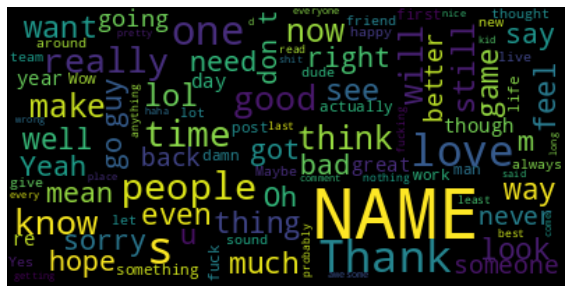

In [78]:
text = " ".join(cat for cat in df_train["Text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

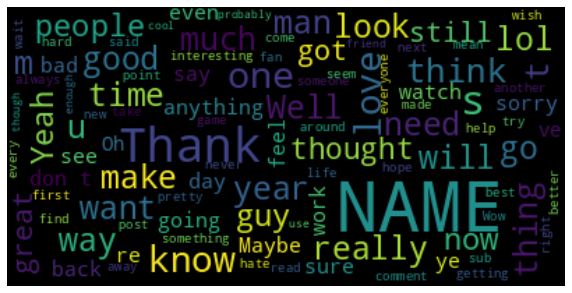

In [79]:
text = " ".join(cat for cat in df_val["Text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

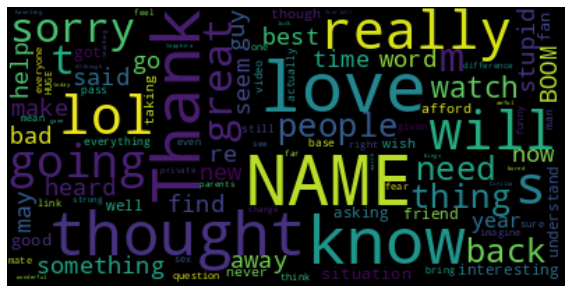

In [80]:
text = " ".join(cat for cat in df_test["Text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Preprocessing

In [81]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stopwords = stopwords.words('english')

def lower_text(text):
    return text.lower()

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text
    
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text


def clean_text(text):
    text = lower_text(text)
    text = remove_number(text)
    text = remove_punct(text)
    text = remove_stopwords(text)
    
    return text

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
X_train = df_train['Text'].apply(clean_text)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean_text)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean_text)
y_val = df_val['Emotion']

In [83]:
X_train.head()

0                     favourite food anything ' cook .
1    himself, everyone think hes laugh screwing peo...
2                                  fuck bayless isoing
3                                 make feel threatened
4                               dirty southern wankers
Name: Text, dtype: object

In [84]:
y_train.head()

0    neutral
1    neutral
2      anger
3       fear
4      anger
Name: Emotion, dtype: object

In [85]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [86]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 5933


### GloVE embeddings

In [87]:
path_to_glove_file = '../input/sadfghj/glove.6B.100d.txt'
num_tokens = vocabSize
embedding_dim = 100
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("%d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
5510 words (422 misses)


### BILSTM

In [88]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 100, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 256, 100)          593300    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 256, 512)          731136    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 256, 256)          656384    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
Total params: 2,376,859
Trainable params: 1,783,559
Non-trainable params: 593,300
_________________________________________________________________


### EarlyStopping

In [89]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [90]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30
#                     callbacks=[callback]
                   )

Epoch 1/30
12/12 [==============================] - 87s 6s/step - loss: 1.5850 - accuracy: 0.3717 - val_loss: 1.6176 - val_accuracy: 0.3800
Epoch 2/30
12/12 [==============================] - 73s 6s/step - loss: 1.4396 - accuracy: 0.4657 - val_loss: 1.4639 - val_accuracy: 0.4200
Epoch 3/30
12/12 [==============================] - 74s 6s/step - loss: 1.3105 - accuracy: 0.5173 - val_loss: 1.3582 - val_accuracy: 0.4900
Epoch 4/30
12/12 [==============================] - 73s 6s/step - loss: 1.2359 - accuracy: 0.5383 - val_loss: 1.3697 - val_accuracy: 0.5000
Epoch 5/30
12/12 [==============================] - 74s 6s/step - loss: 1.1635 - accuracy: 0.5740 - val_loss: 1.2768 - val_accuracy: 0.6100
Epoch 6/30
12/12 [==============================] - 73s 6s/step - loss: 1.1094 - accuracy: 0.5960 - val_loss: 1.2871 - val_accuracy: 0.5400
Epoch 7/30
12/12 [==============================] - 74s 6s/step - loss: 1.1353 - accuracy: 0.6000 - val_loss: 1.3260 - val_accuracy: 0.5200
Epoch 8/30
12/12 [==

In [91]:
model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 11s 340ms/step - loss: 2.5952 - accuracy: 0.5340


[2.5951826572418213, 0.5339999794960022]

### Visualize loss and accuracy

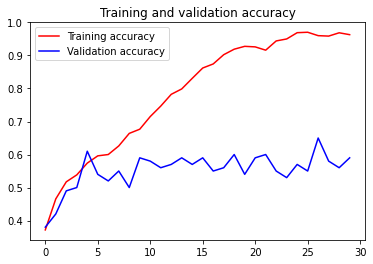

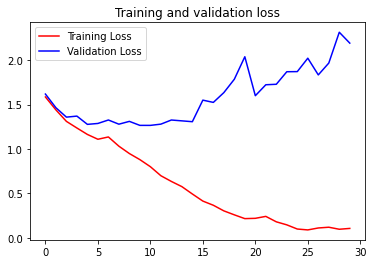

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Prediction

In [124]:
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)

## Metrics

In [127]:
labelEmotions = {'neutral': 0, 'anger': 1, 'fear': 2, 'suprise': 3, 'joy': 4,'sadness': 5,'disgust':6}

In [130]:
colors = ['#ffffff', '#fbcbff', '#707bfb']
cmap = LinearSegmentedColormap.from_list('mycmap', colors)

def plot_confusion_matrix(matrix, fmt=''):
  plt.figure(figsize=(15, 15))
  sns.heatmap(matrix, annot=True, 
              cmap=cmap, 
              fmt=fmt, 
              xticklabels=labelEmotions.keys(), 
              yticklabels=labelEmotions.keys())
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels')
  plt.show()

### Confusion matrix

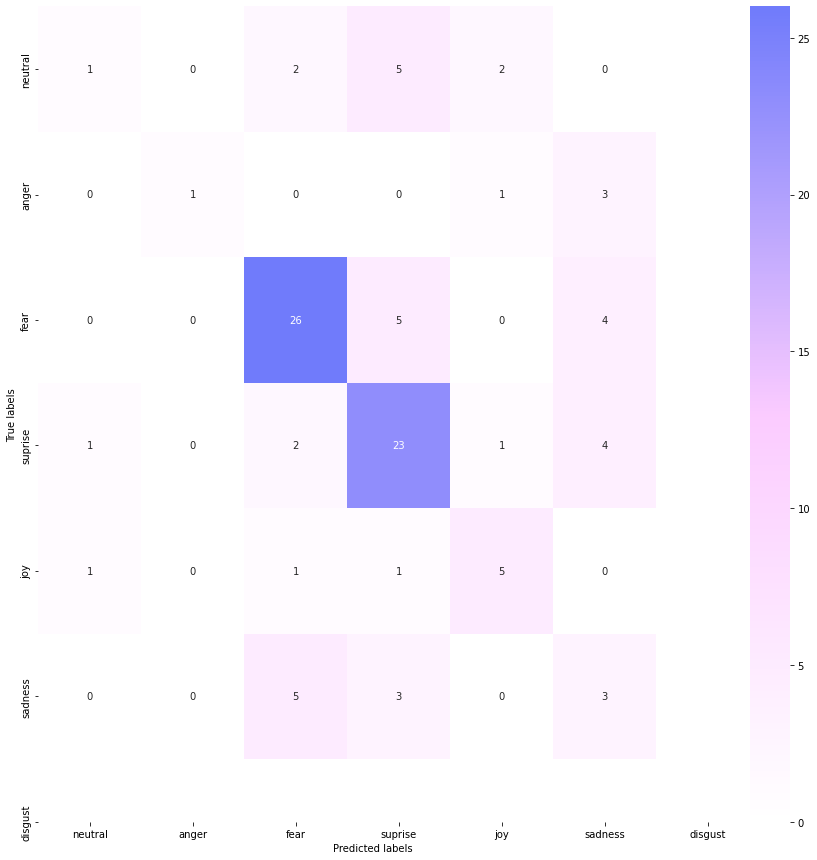

In [131]:
matrix=metrics.confusion_matrix(y_test_arg, Y_pred)
plot_confusion_matrix(matrix)

### classification report

In [132]:
print(metrics.classification_report(y_test_arg, Y_pred))

              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           2       1.00      0.20      0.33         5
           3       0.72      0.74      0.73        35
           4       0.62      0.74      0.68        31
           5       0.56      0.62      0.59         8
           6       0.21      0.27      0.24        11

    accuracy                           0.59       100
   macro avg       0.57      0.45      0.45       100
weighted avg       0.60      0.59      0.57       100

